<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/Long_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install evaluate
!pip install sentencepiece
!pip install rouge_score

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import neccessary modules
  - model
  - dataset
  - metric

In [ ]:
from transformers import AutoTokenizer, LongT5ForConditionalGeneration, T5ForConditionalGeneration
from datasets import load_dataset, load_metric
import torch
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pprint import pprint

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("google/longt5-local-base")
# model = LongT5ForConditionalGeneration.from_pretrained("google/longt5-local-base")
# tokenizer = AutoTokenizer.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")
# model = LongT5ForConditionalGeneration.from_pretrained("Stancld/longt5-tglobal-large-16384-pubmed-3k_steps")
tokenizer = AutoTokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
dataset = load_dataset("cnn_dailymail", '3.0.0')
metric = load_metric('rouge')

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:01<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

# Simple EDA

In [ ]:
df = dataset['train'].to_pandas()

In [ ]:
df['article_text_count'] = df['article'].apply(lambda x: len(x.split(' ')))
df['highlight_text_count'] = df['highlights'].apply(lambda x: len(x.split(' ')))

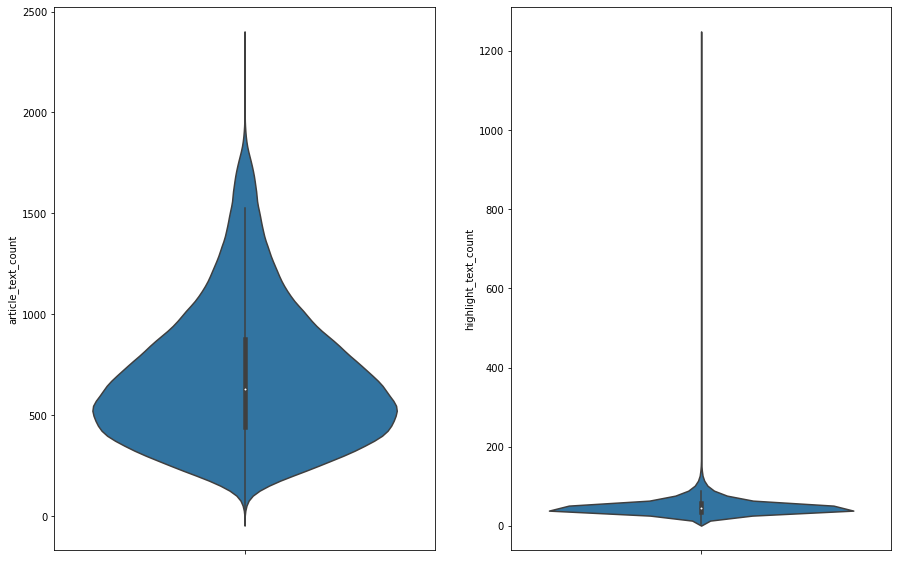

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
sns.violinplot(data=df, y='article_text_count',)

plt.subplot(1, 2, 2)
sns.violinplot(data=df, y='highlight_text_count')

In [ ]:
sample = df.sample(1)
sample

,article,highlights,id,article_text_count,highlight_text_count
6146,(CNN) -- Fans around the world have gathered ...,"""Sadness Party"" held in Berlin, where fans fol...",4ecdacaba1f3532087bf4fcb51d0c0f00021f0b0,883,53


In [ ]:
print('Long Text')
pprint(sample['article'].iloc[0])

print('\nSummarize')
pprint(sample['highlights'].iloc[0])

Long Text
('(CNN)  -- Fans around the world have gathered at arenas and record stores, '
 'big screens, parks and makeshift shrines, to watch the memorial service of '
 'Michael Jackson and pay homage to their idol. A Michael Jackson fan in '
 'Berlin watches footage of the memorial concert. As thousands of fans joined '
 "Jackson's family and closest friends at Los Angeles Staples Center arena, "
 'millions more followed proceedings on television and online. In Germany, at '
 'least 8,000 Jackson fans watched events in Los Angeles unfold at a '
 'Trauerfeier," (translated as Sadness Party) at Berlin\'s O2 World arena, '
 "reported CNN's Frederik Pleitgen.   Fans began arriving at least three hours "
 'before the event was due to begin, Pleitgen said. "He [Jackson] connects '
 'races, religions and ages," said one fan, "his music connects the world." '
 "Many fans were moved to tears when Jackson's daughter Paris Katherine wept "
 'as she called the singer "the best father you could ev

# Prepare dataset

In [ ]:
prefix='summary:'
def prepare_input(examples):
  inputs = [prefix + doc for doc in examples['article']]
  model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

  with tokenizer.as_target_tokenizer():
      labels = tokenizer(examples["highlights"], max_length=128, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

In [ ]:
encoded_dataset = dataset.map(prepare_input, batched=True)

Parameter 'function'=<function prepare_input at 0x7f01d04c8b00> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/288 [00:00<?, ?ba/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Train model

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  if isinstance(preds, tuple):
      preds = preds[0]
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if data_args.ignore_pad_token_for_loss:
      # Replace -100 in the labels as we can't decode them.
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Some simple post-processing
  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
  # Extract a few results from ROUGE
  result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  result = {k: round(v, 4) for k, v in result.items()}
  return result

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    fp16=False,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, article, highlights. If id, article, highlights are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 287113
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 143558


Epoch,Training Loss,Validation Loss


RuntimeError: ignored